In [1]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from Bio import SeqIO
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, MaxPooling1D, Flatten, Dense
import os
import random

In [2]:
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [3]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
def evaluate_model(model, X_val = None, X_val_pt5 = None, y_val=None):
    y_true = y_val
    # Predict probabilities (or logits if using `from_logits=True`).
    if X_val_pt5 is None:
        y_pred_probs = model.predict(X_val)
    elif X_val is None:
        y_pred_probs = model.predict(X_val_pt5)
    else:
        y_pred_probs = model.predict([X_val, X_val_pt5])

    # Convert probabilities/logits to binary predictions (threshold = 0.5).
    y_pred = (y_pred_probs > 0.5).astype(int)

    # If y_true is one-hot encoded, convert it to binary format
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
        y_true = np.argmax(y_true, axis=1)  # Convert one-hot encoded y_true to binary labels

    # Ensure y_pred is also 1D
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)  # Convert y_pred to binary labels if necessary

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    auprc = average_precision_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Compute Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Print the results
    print(f'Accuracy: {accuracy}')
    print(f'MCC: {mcc}')
    print(f'AUC: {auc}')
    print(f'AUPRC: {auprc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Specificity: {specificity}')
    print(f'F1: {f1}')

    return accuracy, mcc, auc, auprc, precision, recall, specificity, f1

In [4]:
from keras.layers import Input, Embedding, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def create_conv_branch(input_shape_conv):
    conv_input = Input(shape=input_shape_conv, name='conv_input')

    # Embedding layer
    x = Embedding(input_dim=256, output_dim=21, input_length=input_shape_conv[0])(conv_input)

    x = Lambda(lambda x: tf.expand_dims(x, 3))(x)

    # Convolutional layers
    x = Conv2D(32, kernel_size=(17, 3), activation='relu',
               kernel_initializer='he_normal', padding='VALID')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)

    x = Dense(16, activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(0.2)(x)

    # Output of convolutional branch
    conv_output = Dense(16, activation='relu', name='conv_output')(x)

    conv_output = Dense(1, activation='sigmoid')(conv_output)

    model = Model(inputs=conv_input, outputs=conv_output, name='conv_branch')

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model
# # Instantiate the convolutional branch
# conv_branch = create_conv_branch((33,))

# # Train the convolutional branch
# conv_history = conv_branch.fit(
#     X_train, y_train,
#     epochs=100,
#     batch_size=256,
#     verbose=1,
#     validation_data=(X_val, y_val),
#     callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
# )

# # Optionally, save the trained weights
# conv_branch.save_weights('conv_branch.weights.h5')


In [6]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model

def create_ann_branch(input_shape_ann):
    ann_input = Input(shape=(input_shape_ann,), name='ann_input')

    x = Dense(256, activation='relu')(ann_input)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)

    # Output of ANN branch
    ann_output = Dense(1, activation='sigmoid', name='ann_output')(x)

    model = Model(inputs=ann_input, outputs=ann_output, name='ann_branch')

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

# # Instantiate the ANN branch
# ann_branch = create_ann_branch(1024)

# # Train the ANN branch
# ann_history = ann_branch.fit(
#     X_train_pt5, y_train,
#     epochs=100,
#     batch_size=256,
#     verbose=1,
#     validation_data=(X_val_pt5, y_val),
#     callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
# )

# # Optionally, save the trained weights
# ann_branch.save_weights('ann_branch.weights.h5')


In [7]:
from keras.layers import Concatenate, Dense
from keras.models import Model

def create_combined_model(conv_branch, ann_branch):
    # Freeze the branches if you don't want to train them initially
    conv_branch.trainable = False
    ann_branch.trainable = False

    # Define inputs
    conv_input = conv_branch.input
    ann_input = ann_branch.input

    # Get outputs from the branches
    conv_output = conv_branch.get_layer(index=6).output
    ann_output = ann_branch.get_layer(index=4).output

    # Concatenate the outputs
    combined = Concatenate()([conv_output, ann_output])

    # Add combined layers
    x = Dense(16, activation='relu')(combined)
    x = Dense(4, activation='relu')(x)
    output = Dense(1, activation='sigmoid', name='output')(x)

    # Define the combined model
    combined_model = Model(inputs=[conv_input, ann_input], outputs=output, name='combined_model')

    # Compile the combined model
    combined_model.compile(optimizer=Adam(learning_rate=0.001),
                           loss=BinaryCrossentropy(),
                           metrics=['accuracy'])

    return combined_model

# # If you saved the weights separately, load them
# conv_branch.load_weights('conv_branch.weights.h5')
# ann_branch.load_weights('ann_branch.weights.h5')

# # Create the combined model
# combined_model = create_combined_model(conv_branch, ann_branch)

# # View the summary
# combined_model.summary()

# # Train the combined model
# combined_history = combined_model.fit(
#     [X_train, X_train_pt5], y_train,
#     epochs=100,
#     batch_size=256,
#     verbose=1,
#     validation_data=([X_val, X_val_pt5], y_val),
#     callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
# )


# # Evaluate the model
# evaluate_model(combined_model, X_val, X_val_pt5, y_val)
# evaluate_model(combined_model, X_test, X_test_pt5, y_test)




Load Data, Train and Save Final Model:

In [8]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

train = pd.read_csv('../Embeddings/Prot_t5/train_t5.csv')
val = pd.read_csv('../Embeddings/Prot_t5/val_t5.csv')
test = pd.read_csv('../Embeddings/Prot_t5/test_t5.csv')

print(train.shape)
print(val.shape)
print(test.shape)

# Convert the embedding strings to numpy arrays
X_train_embeddings = train['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_val_embeddings = val['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_test_embeddings = test['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))

# Convert to a numpy array if needed
X_train_embeddings = np.stack(X_train_embeddings.values)
X_val_embeddings = np.stack(X_val_embeddings.values)
X_test_embeddings = np.stack(X_test_embeddings.values)

# Extract sequences
X_train = train['sequence'].values
X_val = val['sequence'].values
X_test = test['sequence'].values

# Extract labels
y_train = train['label'].values
y_val = val['label'].values
y_test = test['label'].values

# Create a dictionary to map amino acids to integers
amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'

aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

# Convert the sequences to a numerical format and convert to numpy arrays
X_train_num = [[aa_to_int[aa] for aa in seq] for seq in X_train]
X_val_num = [[aa_to_int[aa] for aa in seq] for seq in X_val]
X_test_num = [[aa_to_int[aa] for aa in seq] for seq in X_test]

X_train_num = np.array(X_train_num)
X_val_num = np.array(X_val_num)
X_test_num = np.array(X_test_num)

set_seed(4)

conv_branch = create_conv_branch((33,))

# Train the convolutional branch
conv_history = conv_branch.fit(
    X_train_num, y_train,
    epochs=100,
    batch_size=256,
    verbose=0,
    validation_data=(X_val_num, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# # Instantiate the ANN branch
ann_branch = create_ann_branch(1024)

# Train the ANN branch
ann_history = ann_branch.fit(
    X_train_embeddings, y_train,
    epochs=100,
    batch_size=256,
    verbose=0,
    validation_data=(X_val_embeddings, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Create the combined model
combined_model = create_combined_model(conv_branch, ann_branch)

# View the summary
combined_model.summary()

# Train the combined model
combined_history = combined_model.fit(
    [X_train_num, X_train_embeddings], y_train,
    epochs=100,
    batch_size=256,
    verbose=1,
    validation_data=([X_val_num, X_val_embeddings], y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Evaluate the model
evaluate_model(combined_model, X_val=X_val_num, X_val_pt5=X_val_embeddings, y_val=y_val)
evaluate_model(combined_model, X_val=X_test_num, X_val_pt5=X_test_embeddings, y_val=y_test)

#save the model
combined_model.save('Models/LMSuccSite.h5')
combined_model.save_weights('Models/LMSuccSite.weights.h5')

(8411, 5)
(935, 5)
(3226, 5)


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "combined_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ conv_input          │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 33, 21)    │      5,376 │ conv_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 33, 21, 1) │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ann_input           │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 17, 19,    │      1,664 │ lambda[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    262,400 │ ann_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 17, 19,    │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 8, 9, 32)  │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2304)      │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2432)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │     38,928 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │         68 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │          5 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 341,337 (1.30 MB)

 Trainable params: 39,001 (152.35 KB)

 Non-trainable params: 302,336 (1.15 MB)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6297 - loss: 0.6589 - val_accuracy: 0.7668 - val_loss: 0.5667
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7879 - loss: 0.5236 - val_accuracy: 0.7701 - val_loss: 0.4994
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8115 - loss: 0.4320 - val_accuracy: 0.7754 - val_loss: 0.4804
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8162 - loss: 0.4008 - val_accuracy: 0.7786 - val_loss: 0.4752
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8257 - loss: 0.3846 - val_accuracy: 0.7807 - val_loss: 0.4717
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8362 - loss: 0.3724 - val_accuracy: 0.7872 - val_loss: 0.4697
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8348 - loss: 0.3660 - val_accuracy: 0.7904 - val_loss: 0.4665
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8420 - loss: 0.3574 - val_accuracy: 0.

Accuracy: 0.7625542467451953
MCC: 0.33446819290404073
AUC: 0.7807686836335983
AUPRC: 0.3155356056713083
Precision: 0.22089227421109903
Recall: 0.8023715415019763
Specificity: 0.7591658257652203
F1: 0.3464163822525597


Permutation test :

In [7]:
#read train and test datasets

train = pd.read_csv('../Embeddings/Prot_t5/train_t5.csv')
val = pd.read_csv('../Embeddings/Prot_t5/val_t5.csv')
test = pd.read_csv('../Embeddings/Prot_t5/test_t5.csv')

print(train.shape)
print(val.shape)
print(test.shape)

# Convert the embedding strings to numpy arrays
X_train_embeddings = train['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_val_embeddings = val['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_test_embeddings = test['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))

# Convert to a numpy array if needed
X_train_embeddings = np.stack(X_train_embeddings.values)
X_val_embeddings = np.stack(X_val_embeddings.values)
X_test_embeddings = np.stack(X_test_embeddings.values)

# Extract sequences
X_train = train['sequence'].values
X_val = val['sequence'].values
X_test = test['sequence'].values

# Extract labels
y_train = train['label'].values
y_val = val['label'].values
y_test = test['label'].values

# Create a dictionary to map amino acids to integers
amino_acids_perm = [
''.join(np.random.permutation(list('ACDEFGHIKLMNPQRSTVWY-'))) for _ in range(20)
]

accuracys = []
mccs = []
aucs = []
auprcs = []
precisions = []
recalls = []
specificitys = []
f1s = []

for amino_acids in amino_acids_perm:
    aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

    # Convert the sequences to a numerical format and convert to numpy arrays
    X_train_num = [[aa_to_int[aa] for aa in seq] for seq in X_train]
    X_val_num = [[aa_to_int[aa] for aa in seq] for seq in X_val]
    X_test_num = [[aa_to_int[aa] for aa in seq] for seq in X_test]

    X_train_num = np.array(X_train_num)
    X_val_num = np.array(X_val_num)
    X_test_num = np.array(X_test_num)

    set_seed(4)

    # Instantiate the convolutional branch
    conv_branch = create_conv_branch((33,))

    # Train the convolutional branch
    conv_history = conv_branch.fit(
        X_train_num, y_train,
        epochs=100,
        batch_size=256,
        verbose=0,
        validation_data=(X_val_num, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    # # Instantiate the ANN branch
    ann_branch = create_ann_branch(1024)

    # Train the ANN branch
    ann_history = ann_branch.fit(
        X_train_embeddings, y_train,
        epochs=100,
        batch_size=256,
        verbose=0,
        validation_data=(X_val_embeddings, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    # Create the combined model
    combined_model = create_combined_model(conv_branch, ann_branch)

    # View the summary
    # combined_model.summary()

    # Train the combined model
    combined_history = combined_model.fit(
        [X_train_num, X_train_embeddings], y_train,
        epochs=100,
        batch_size=256,
        verbose=1,
        validation_data=([X_val_num, X_val_embeddings], y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    # Evaluate the model
    acc, mcc, auc, auprc, precision, recall, specificity, f1 = evaluate_model(combined_model, X_val=X_val_num, X_val_pt5=X_val_embeddings, y_val=y_val)

    evaluate_model(combined_model, X_val=X_test_num, X_val_pt5=X_test_embeddings, y_val=y_test)

    accuracys.append(acc)
    mccs.append(mcc)
    aucs.append(auc)
    auprcs.append(auprc)
    precisions.append(precision)
    recalls.append(recall)
    specificitys.append(specificity)
    f1s.append(f1)

# Print the results mean and std
print(f'Accuracy: {np.mean(accuracys)} +/- {np.std(accuracys)}')
print(f'MCC: {np.mean(mccs)} +/- {np.std(mccs)}')
print(f'AUC: {np.mean(aucs)} +/- {np.std(aucs)}')
print(f'AUPRC: {np.mean(auprcs)} +/- {np.std(auprcs)}')
print(f'Precision: {np.mean(precisions)} +/- {np.std(precisions)}')
print(f'Recall: {np.mean(recalls)} +/- {np.std(recalls)}')
print(f'Specificity: {np.mean(specificitys)} +/- {np.std(specificitys)}')
print(f'F1: {np.mean(f1s)} +/- {np.std(f1s)}')

(8411, 5)
(935, 5)
(3226, 5)


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6262 - loss: 0.6860 - val_accuracy: 0.7668 - val_loss: 0.6512
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7829 - loss: 0.6158 - val_accuracy: 0.7786 - val_loss: 0.5484
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7929 - loss: 0.4949 - val_accuracy: 0.7743 - val_loss: 0.4895
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8019 - loss: 0.4331 - val_accuracy: 0.7754 - val_loss: 0.4842
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8146 - loss: 0.4101 - val_accuracy: 0.7754 - val_loss: 0.4853
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8190 - loss: 0.3995 - val_accuracy: 0.7690 - val_loss: 0.4860
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8174 - loss: 0.3932 - val_accuracy: 0.7701 - val_loss: 0.4875
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8207 - loss: 0.3900 - val_accuracy: 0

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6391 - loss: 0.6855 - val_accuracy: 0.7583 - val_loss: 0.6536
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7700 - loss: 0.6252 - val_accuracy: 0.7679 - val_loss: 0.5617
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7845 - loss: 0.5155 - val_accuracy: 0.7668 - val_loss: 0.4958
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7968 - loss: 0.4479 - val_accuracy: 0.7690 - val_loss: 0.4854
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8110 - loss: 0.4197 - val_accuracy: 0.7668 - val_loss: 0.4881
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8174 - loss: 0.4075 - val_accuracy: 0.7722 - val_loss: 0.4898
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8137 - loss: 0.4020 - val_accuracy: 0.7775 - val_loss: 0.4893
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8209 - loss: 0.3970 - val_accuracy: 0.

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6492 - loss: 0.6864 - val_accuracy: 0.7594 - val_loss: 0.6582
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7815 - loss: 0.6298 - val_accuracy: 0.7679 - val_loss: 0.5696
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7891 - loss: 0.5204 - val_accuracy: 0.7690 - val_loss: 0.4983
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8015 - loss: 0.4479 - val_accuracy: 0.7690 - val_loss: 0.4845
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8090 - loss: 0.4194 - val_accuracy: 0.7690 - val_loss: 0.4862
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8188 - loss: 0.4082 - val_accuracy: 0.7701 - val_loss: 0.4859
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8165 - loss: 0.4042 - val_accuracy: 0.7733 - val_loss: 0.4830
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8183 - loss: 0.3979 - val_accuracy: 0.

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


KeyboardInterrupt: 

Cross validation :

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6262 - loss: 0.6530 - val_accuracy: 0.7497 - val_loss: 0.5712
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8104 - loss: 0.5068 - val_accuracy: 0.7647 - val_loss: 0.5025
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8277 - loss: 0.4173 - val_accuracy: 0.7668 - val_loss: 0.4864
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8441 - loss: 0.3767 - val_accuracy: 0.7668 - val_loss: 0.4859
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8426 - loss: 0.3661 - val_accuracy: 0.7711 - val_loss: 0.4853
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8524 - loss: 0.3585 - val_accuracy: 0.7743 - val_loss: 0.4831
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8485 - loss: 0.3564 - val_accuracy: 0.7775 - val_loss: 0.4832
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8529 - loss: 0.3448 - val_accuracy: 0.

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6243 - loss: 0.6530 - val_accuracy: 0.7390 - val_loss: 0.5777
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8059 - loss: 0.5052 - val_accuracy: 0.7583 - val_loss: 0.5066
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8262 - loss: 0.4194 - val_accuracy: 0.7636 - val_loss: 0.4903
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8316 - loss: 0.3966 - val_accuracy: 0.7679 - val_loss: 0.4890
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8388 - loss: 0.3839 - val_accuracy: 0.7679 - val_loss: 0.4820
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8364 - loss: 0.3762 - val_accuracy: 0.7754 - val_loss: 0.4760
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8423 - loss: 0.3641 - val_accuracy: 0.7754 - val_loss: 0.4757
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8490 - loss: 0.3609 - val_accuracy: 0.

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5942 - loss: 0.6677 - val_accuracy: 0.7027 - val_loss: 0.6057
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7931 - loss: 0.5295 - val_accuracy: 0.7369 - val_loss: 0.5370
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8085 - loss: 0.4391 - val_accuracy: 0.7455 - val_loss: 0.5242
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8171 - loss: 0.4106 - val_accuracy: 0.7551 - val_loss: 0.5209
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8184 - loss: 0.3986 - val_accuracy: 0.7540 - val_loss: 0.5135
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8285 - loss: 0.3922 - val_accuracy: 0.7561 - val_loss: 0.5062
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8302 - loss: 0.3865 - val_accuracy: 0.7679 - val_loss: 0.5011
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8330 - loss: 0.3810 - val_accuracy: 0.

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6191 - loss: 0.6612 - val_accuracy: 0.7422 - val_loss: 0.5899
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7901 - loss: 0.5289 - val_accuracy: 0.7433 - val_loss: 0.5254
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8059 - loss: 0.4477 - val_accuracy: 0.7508 - val_loss: 0.5116
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8106 - loss: 0.4216 - val_accuracy: 0.7433 - val_loss: 0.5078
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8183 - loss: 0.4071 - val_accuracy: 0.7561 - val_loss: 0.5027
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8214 - loss: 0.3954 - val_accuracy: 0.7604 - val_loss: 0.4994
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8283 - loss: 0.3857 - val_accuracy: 0.7561 - val_loss: 0.4960
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8401 - loss: 0.3756 - val_accuracy: 0.

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6404 - loss: 0.6879 - val_accuracy: 0.7326 - val_loss: 0.6594
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7760 - loss: 0.6306 - val_accuracy: 0.7508 - val_loss: 0.5707
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7867 - loss: 0.5223 - val_accuracy: 0.7583 - val_loss: 0.5071
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7926 - loss: 0.4526 - val_accuracy: 0.7626 - val_loss: 0.4915
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8077 - loss: 0.4349 - val_accuracy: 0.7668 - val_loss: 0.4843
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8105 - loss: 0.4213 - val_accuracy: 0.7701 - val_loss: 0.4813
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8139 - loss: 0.4101 - val_accuracy: 0.7701 - val_loss: 0.4779
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8136 - loss: 0.4107 - val_accuracy: 0.

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6021 - loss: 0.6606 - val_accuracy: 0.7380 - val_loss: 0.5819
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7809 - loss: 0.5333 - val_accuracy: 0.7733 - val_loss: 0.5042
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8032 - loss: 0.4522 - val_accuracy: 0.7722 - val_loss: 0.4835
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8099 - loss: 0.4199 - val_accuracy: 0.7733 - val_loss: 0.4867
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8149 - loss: 0.4117 - val_accuracy: 0.7743 - val_loss: 0.4744
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8219 - loss: 0.3998 - val_accuracy: 0.7765 - val_loss: 0.4712
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8261 - loss: 0.3898 - val_accuracy: 0.7754 - val_loss: 0.4733
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8297 - loss: 0.3941 - val_accuracy: 0.

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6029 - loss: 0.6700 - val_accuracy: 0.7120 - val_loss: 0.6043
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7778 - loss: 0.5417 - val_accuracy: 0.7452 - val_loss: 0.5367
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7958 - loss: 0.4548 - val_accuracy: 0.7463 - val_loss: 0.5203
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8089 - loss: 0.4215 - val_accuracy: 0.7398 - val_loss: 0.5183
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8150 - loss: 0.4046 - val_accuracy: 0.7452 - val_loss: 0.5186
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8235 - loss: 0.3912 - val_accuracy: 0.7516 - val_loss: 0.5161
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8267 - loss: 0.3833 - val_accuracy: 0.7495 - val_loss: 0.5131
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8344 - loss: 0.3734 - val_accuracy: 0.

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6192 - loss: 0.6901 - val_accuracy: 0.7377 - val_loss: 0.6707
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7678 - loss: 0.6471 - val_accuracy: 0.7409 - val_loss: 0.5962
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7800 - loss: 0.5460 - val_accuracy: 0.7430 - val_loss: 0.5327
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7925 - loss: 0.4668 - val_accuracy: 0.7355 - val_loss: 0.5239
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7991 - loss: 0.4411 - val_accuracy: 0.7398 - val_loss: 0.5252
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8005 - loss: 0.4308 - val_accuracy: 0.7484 - val_loss: 0.5241
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8046 - loss: 0.4202 - val_accuracy: 0.7463 - val_loss: 0.5236
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8083 - loss: 0.4170 - val_accuracy: 0.

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6224 - loss: 0.6518 - val_accuracy: 0.7270 - val_loss: 0.5927
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7770 - loss: 0.5229 - val_accuracy: 0.7388 - val_loss: 0.5453
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7971 - loss: 0.4526 - val_accuracy: 0.7409 - val_loss: 0.5387
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7965 - loss: 0.4353 - val_accuracy: 0.7409 - val_loss: 0.5283
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8072 - loss: 0.4182 - val_accuracy: 0.7463 - val_loss: 0.5255
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8203 - loss: 0.4060 - val_accuracy: 0.7516 - val_loss: 0.5217
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8229 - loss: 0.3989 - val_accuracy: 0.7527 - val_loss: 0.5184
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8229 - loss: 0.3936 - val_accuracy: 0.

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5468 - loss: 0.6891 - val_accuracy: 0.7430 - val_loss: 0.6689
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7828 - loss: 0.6429 - val_accuracy: 0.7527 - val_loss: 0.5824
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7948 - loss: 0.5270 - val_accuracy: 0.7602 - val_loss: 0.5072
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8042 - loss: 0.4435 - val_accuracy: 0.7580 - val_loss: 0.4894
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8115 - loss: 0.4144 - val_accuracy: 0.7612 - val_loss: 0.4867
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8210 - loss: 0.4045 - val_accuracy: 0.7687 - val_loss: 0.4849
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8165 - loss: 0.3977 - val_accuracy: 0.7602 - val_loss: 0.4836
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8168 - loss: 0.3954 - val_accuracy: 0.

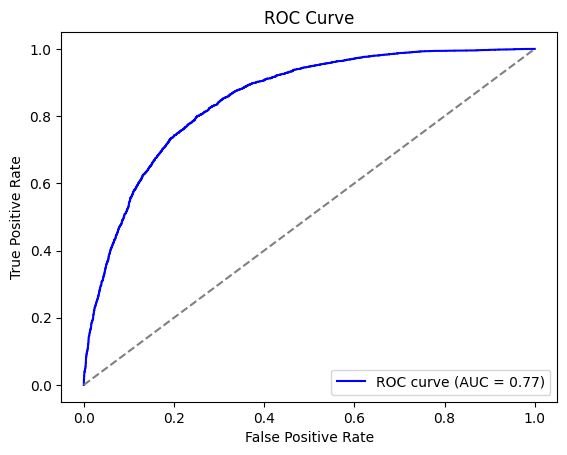

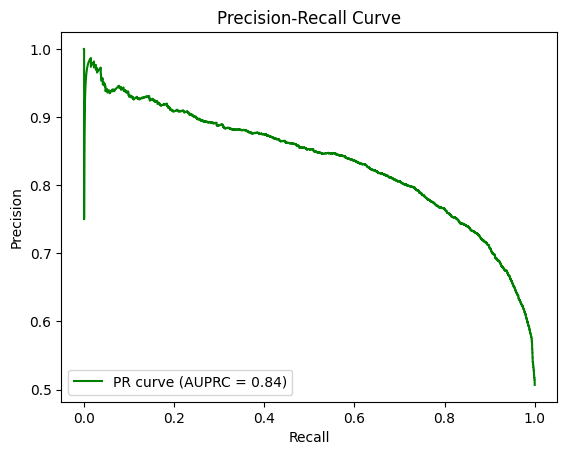

In [11]:
# 10 fold cross validation
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

X_train_num = np.concatenate((X_train_num, X_val_num), axis=0)
X_train_embeddings = np.concatenate((X_train_embeddings, X_val_embeddings), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)

kf = KFold(n_splits=10, shuffle=True, random_state=4)

# Initialize lists to collect predictions and true labels across folds
y_pred_list = []
y_pred_proba_list = []
y_true_list = []

accuracys = []
mccs = []
aucs = []
auprcs = []
precisions = []
recalls = []
specificitys = []
f1s = []

for train_index, val_index in kf.split(X_train_num):
    X_train_num_fold, X_val_num_fold = X_train_num[train_index], X_train_num[val_index]
    X_train_embeddings_fold, X_val_embeddings_fold = X_train_embeddings[train_index], X_train_embeddings[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    set_seed(4)

    # Instantiate and train the convolutional branch
    conv_branch = create_conv_branch((33,))
    conv_history = conv_branch.fit(
        X_train_num_fold, y_train_fold,
        epochs=100,
        batch_size=256,
        verbose=0,
        validation_data=(X_val_num_fold, y_val_fold),
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    # Instantiate and train the ANN branch
    ann_branch = create_ann_branch(1024)
    ann_history = ann_branch.fit(
        X_train_embeddings_fold, y_train_fold,
        epochs=100,
        batch_size=256,
        verbose=0,
        validation_data=(X_val_embeddings_fold, y_val_fold),
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    # Create the combined model
    combined_model = create_combined_model(conv_branch, ann_branch)

    # Train the combined model
    combined_history = combined_model.fit(
        [X_train_num_fold, X_train_embeddings_fold], y_train_fold,
        epochs=100,
        batch_size=256,
        verbose=1,
        validation_data=([X_val_num_fold, X_val_embeddings_fold], y_val_fold),
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    # Evaluate the model on the validation fold
    acc, mcc, auc, auprc, precision, recall, specificity, f1 = evaluate_model(
        combined_model, X_val=X_val_num_fold, X_val_pt5=X_val_embeddings_fold, y_val=y_val_fold
    )
    
    # Get predictions and probabilities for the current fold
    y_pred_fold = combined_model.predict([X_val_num_fold, X_val_embeddings_fold]) > 0.5
    y_pred_proba_fold = combined_model.predict([X_val_num_fold, X_val_embeddings_fold])
    
    # Append results to the lists
    y_pred_list.append(y_pred_fold)
    y_pred_proba_list.append(y_pred_proba_fold)
    y_true_list.append(y_val_fold)

    # Store evaluation metrics
    accuracys.append(acc)
    mccs.append(mcc)
    aucs.append(auc)
    auprcs.append(auprc)
    precisions.append(precision)
    recalls.append(recall)
    specificitys.append(specificity)
    f1s.append(f1)

# Concatenate results across all folds
y_pred_all = np.concatenate(y_pred_list)
y_pred_proba_all = np.concatenate(y_pred_proba_list)
y_true_all = np.concatenate(y_true_list)

# Print the evaluation results
print(f'Accuracy: {np.mean(accuracys)} +/- {np.std(accuracys)}')
print(f'MCC: {np.mean(mccs)} +/- {np.std(mccs)}')
print(f'AUC: {np.mean(aucs)} +/- {np.std(aucs)}')
print(f'AUPRC: {np.mean(auprcs)} +/- {np.std(auprcs)}')
print(f'Precision: {np.mean(precisions)} +/- {np.std(precisions)}')
print(f'Recall: {np.mean(recalls)} +/- {np.std(recalls)}')
print(f'Specificity: {np.mean(specificitys)} +/- {np.std(specificitys)}')
print(f'F1: {np.mean(f1s)} +/- {np.std(f1s)}')

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true_all, y_pred_proba_all)
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % np.mean(aucs))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_all, y_pred_proba_all)
plt.figure()
plt.plot(recall, precision, color='green', label='PR curve (AUPRC = %0.2f)' % np.mean(auprcs))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()




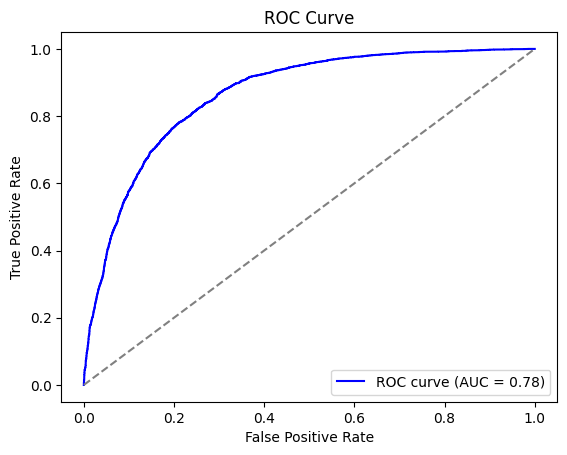

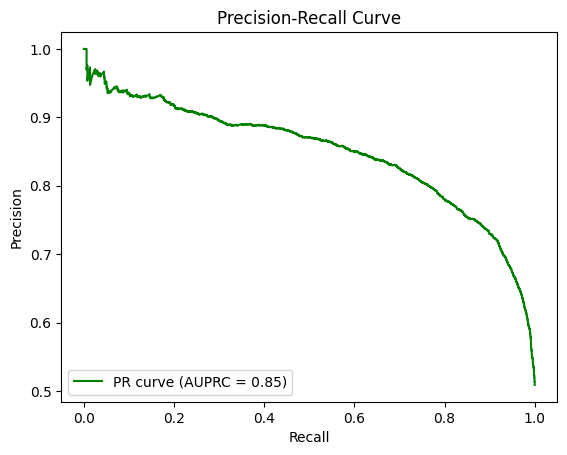

In [13]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true_all, y_pred_proba_all)
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % np.mean(aucs))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('Plots/ROC_LMSuccSite.pdf', format='pdf', bbox_inches='tight') 
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_all, y_pred_proba_all)
plt.figure()
plt.plot(recall, precision, color='green', label='PR curve (AUPRC = %0.2f)' % np.mean(auprcs))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('Plots/PR_LMSuccSite.pdf', format='pdf', bbox_inches='tight') 
plt.show()

In [12]:
#save y_true_all, y_pred_all, y_pred_proba_all to a file
np.save('LM_y_true_all.npy', y_true_all)
np.save('LM_y_pred_all.npy', y_pred_all)
np.save('LM_y_pred_proba_all.npy', y_pred_proba_all)

#load y_true_all, y_pred_all, y_pred_proba_all from a file
y_true_all = np.load('LM_y_true_all.npy')
y_pred_all = np.load('LM_y_pred_all.npy')
y_pred_proba_all = np.load('LM_y_pred_proba_all.npy')

20 random balanced test set:

In [18]:
from sklearn.preprocessing import PowerTransformer

#20 randonly balanced test set
test = pd.read_csv('../Embeddings/Prot_t5/test_t5_pssm.csv')
test_pos = test[test['label'] == 1]
test_neg = test[test['label'] == 0]

accuracies = []
mccs = []
aucs = []
auprcs = []
precisions = []
recalls = []
specificities = []
f1s = []

for i in range(20):
    test_neg = test_neg.sample(n=253, random_state=np.random.randint(0, 10000))

    test= pd.concat([test_pos, test_neg], axis=0)


    X_test_embeddings = test['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
    X_test_PSSM = test['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))
    X_test_PSSM = np.stack(X_test_PSSM.values)
    X_test_embeddings = np.stack(X_test_embeddings.values)
    scaler = PowerTransformer()
    X_test_PSSM = scaler.fit_transform(X_test_PSSM)
    X_test = test['sequence'].values
    y_test = test['label'].values

    # Create a dictionary to map amino acids to integers
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
    aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}
    X_test_num = [[aa_to_int[aa] for aa in seq] for seq in X_test]
    X_test_num = np.array(X_test_num)

    # Evaluate the models
    acc, mcc, auc, auprc, precision, recall, specificity, f1 = evaluate_model(combined_model, X_test_num, X_test_embeddings, y_val=y_test)
    accuracies.append(acc)
    mccs.append(mcc)
    aucs.append(auc)
    auprcs.append(auprc)
    precisions.append(precision)
    recalls.append(recall)
    specificities.append(specificity)
    f1s.append(f1)

print("Results for Residual Model:")
print(f'Accuracy: {np.mean(accuracies)} +- {np.std(accuracies)}')
print(f'MCC: {np.mean(mccs)} +- {np.std(mccs)}')
print(f'AUC: {np.mean(aucs)} +- {np.std(aucs)}')
print(f'AUPRC: {np.mean(auprcs)} +- {np.std(auprcs)}')
print(f'Precision: {np.mean(precisions)} +- {np.std(precisions)}')
print(f'Recall: {np.mean(recalls)} +- {np.std(recalls)}')
print(f'Specificity: {np.mean(specificities)} +- {np.std(specificities)}')
print(f'F1: {np.mean(f1s)} +- {np.std(f1s)}')   

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.7865612648221344
MCC: 0.573409265656776
AUC: 0.7865612648221343
AUPRC: 0.8301515093010355
Precision: 0.7777777777777778
Recall: 0.8023715415019763
Specificity: 0.7707509881422925
F1: 0.7898832684824902
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.7865612648221344
MCC: 0.573409265656776
AUC: 0.7865612648221343
AUPRC: 0.8301515093010355
Precision: 0.7777777777777778
Recall: 0.8023715415019763
Specificity: 0.7707509881422925
F1: 0.7898832684824902
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.7865612648221344
MCC: 0.573409265656776
AUC: 0.7865612648221343
AUPRC: 0.8301515093010355
Precision: 0.7777777777777778
Recall: 0.8023715415019763
Specificity: 0.7707509881422925
F1: 0.7898832684824902
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.7865612648221344
MCC: 0.573409265656776
AUC: 0.7865612648221343
AUPRC: 0.8301515093010355
Precision: 0.7777777777777778
Recall: 0.8023715415019763
Specificity: 0.7707509881422925
F1: 0.7

In [15]:
y_prob = combined_model.predict([X_test_num, X_test_embeddings])
y_pred = (y_prob > 0.5).astype(int)

#save
np.save('LM_y_pred.npy', y_pred)
np.save('LM_y_prob.npy', y_prob)

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
